### Plans & Ideas
* use a part of the data
* sPlot weights as a new feature
  * doesn't make any sense in search for an unlnown signal, but might be useful in reducing bkgr
* uniformity over bkgr
  * handmade losses to prevent similarities between sig and bkgr mass distribution
  * checking it with tests
* weighted AUC
* Focal Loss - https://arxiv.org/abs/1708.02002
* something from tau->3mu
* calibration
* dR antimatching as bkgr samples
* study the effect of including nB - mind that it might introduce simulation dependance of the model!
* add reflections as multiclass
* significance metric
  * optimize output cut on different metrics and compare final significance
* data augmentation
  * somehow expand sideband bkgr into SR

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import graphviz
import itertools

from IPython.display import Image        

from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model, metrics, tree, ensemble
from sklearn.preprocessing import scale, StandardScaler, PolynomialFeatures
from sklearn import utils
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif

# from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, matthews_corrcoef

import lightgbm as lgb
import xgboost as xgb
import shap

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

from auxil import *
# from hep_ml import uboost, gradientboosting as ugb, losses

# import pyDOE
%pylab inline  

sns.__version__

Populating the interactive namespace from numpy and matplotlib


'0.9.0'

### **Getting data**

In [2]:
MC   = pd.read_pickle('MC_pair_dR_psi_renamed.pkl')
# data    = pd.read_pickle('data_B0_e3de87.pkl')
data    = pd.read_pickle('data_B0_e3de87_nB_4000.pkl')

MC_vars = ["dR_mu1", "dR_mu2", "dR_pi1", "dR_pi2", "dR_K1", "dR_K2",
           "dR_mu1_vv", "dR_mu2_vv", "dR_pi1_vv", "dR_pi2_vv", "dR_K1_vv", "dR_K2_vv",
           'gen_phi_mass', 'delta_phi_mass',
           "BU_reflmass1_Cjp", "BU_reflmass2_Cjp"] 

MC.shape, data.shape

((230149, 50), (183406, 34))

In [3]:
data.columns

Index(['psi_eta', 'BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'BU_mass_Cjp',
       'phi_pt', 'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt',
       'JPSI_pvcos2_Cmumu', 'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'psi_pt', 'PI2_pt',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp', 'mu_1_eta', 'K1_eta',
       'BU_pvcos2_Cjp', 'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'JP_eta',
       'PIPI_mass_Cjp'],
      dtype='object')

In [4]:
#### ----- This we would do in the first example case

dR_match = 0.01
matching_mask = ((MC[['dR_mu1', 'dR_mu1_vv']].min(axis=1) < dR_match) & (MC[['dR_mu2', 'dR_mu2_vv']].min(axis=1) < dR_match) & (MC[['dR_pi1', 'dR_pi1_vv']].min(axis=1) < dR_match) &
                 (MC[['dR_pi2', 'dR_pi2_vv']].min(axis=1) < dR_match) & (MC[['dR_K1', 'dR_K1_vv']].min(axis=1) < dR_match) & (MC[['dR_K2', 'dR_K2_vv']].min(axis=1) < dR_match))
signal = MC[matching_mask]

# bkgr = (data[data['BU_mass_Cjp'].between(sig_window['BU_mass_Cjp'][1], sig_window['BU_mass_Cjp'][1] + 0.2) | 
#             data['BU_mass_Cjp'].between(sig_window['BU_mass_Cjp'][0] - 0.2, sig_window['BU_mass_Cjp'][0])]   ) # sidebands

# bkgr = data[data['BU_mass_Cjp'].between(5.45, 5.55) | data['BU_mass_Cjp'].between(5.1, 5.25)] # sidebands


B_window = 0.05; #left_sdbd_dist = 5.366 - 5.25 - B_window
mass_mask_for_bkgr = np.array([True] * data.shape[0])
sig_window = {'BU_mass_Cjp': [5.366 - B_window, 5.366 + B_window]}
### compose a mass window mask
for key, value in sig_window.items():
    mass_mask_for_bkgr &= ((data[key] > value[0] - B_window) & (data[key] < value[0])) | ( (data[key] > value[1]) & (data[key] < value[1] + B_window))
    
bkgr = data[mass_mask_for_bkgr]



#### ----- This is for a conventional train-on-MC way

# signal = data[data['BU_mass_Cjp'].between(5.3, 5.47)] # our signal region
# bkgr = data[data['BU_mass_Cjp'].between(5.2, 5.3) | data['BU_mass_Cjp'].between(5.47, 5.55)] # sidebands
# dR_vars = []

### **Scatterplots**

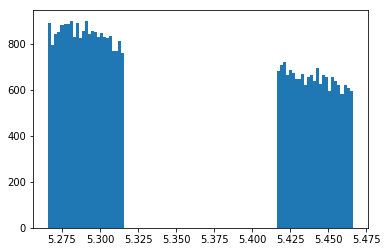

In [5]:
plt.hist(bkgr['BU_mass_Cjp'], bins=100)
plt.show()

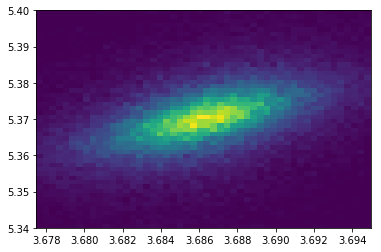

In [6]:
plt.hist2d(x=signal['psi_mass_Cjp'], y=signal['BU_mass_Cjp'], bins=50, range=[[3.6775, 3.695],[5.34, 5.40]])
plt.show()

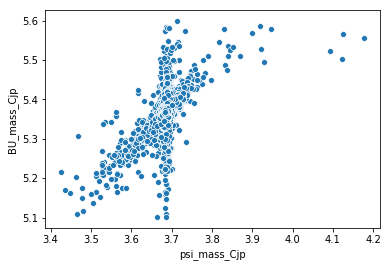

In [7]:
sns.scatterplot(x=signal['psi_mass_Cjp'], y=signal['BU_mass_Cjp'])
plt.savefig('psi_Bs_MC_scatter_0p005.png')

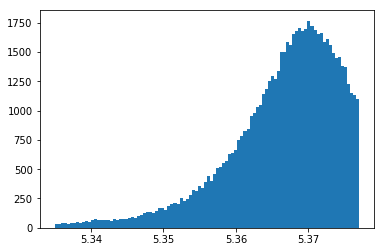

In [8]:
plt.hist(signal['BU_mass_Cjp'], bins=100, range=(5.335, 5.377))
plt.show()

### **Final dataframe for training**

In [9]:
data.columns

Index(['psi_eta', 'BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'BU_mass_Cjp',
       'phi_pt', 'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt',
       'JPSI_pvcos2_Cmumu', 'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'psi_pt', 'PI2_pt',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp', 'mu_1_eta', 'K1_eta',
       'BU_pvcos2_Cjp', 'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'JP_eta',
       'PIPI_mass_Cjp'],
      dtype='object')

In [10]:
drop_vars = [] # ['nB']
drop_masses = ['BU_mass_Cjp', 'psi_mass_Cjp'] # , 'PHI_mass_Cjp', 'psi_mass_Cjp'


signal = signal.drop(drop_vars + MC_vars, axis=1, inplace=False)
bkgr = bkgr.drop(drop_vars, axis=1, inplace=False)[signal.columns]

In [11]:
print(f'Signal shape: {signal.shape[0]}\nBkgr shape: {bkgr.shape[0]}')

Signal shape: 85465
Bkgr shape: 37229


In [12]:
min_shape = min(bkgr.shape[0], signal.shape[0])

bkgr = utils.shuffle(bkgr, random_state=123)[:min_shape] 
signal = utils.shuffle(signal, random_state=123)[:min_shape] 

### make target labels and append sig with bkgr
bkgr['target'] = [0]*bkgr.shape[0]
signal['target'] = [1]*signal.shape[0]
df = bkgr.append(signal)


print('Sig/bkgr shapes:', signal.shape, bkgr.shape)
print('Dataframe shape:', df.shape)
# print('\nNow better')

Sig/bkgr shapes: (37229, 35) (37229, 35)
Dataframe shape: (74458, 35)


In [13]:
signal.head()

,BU_pvdistsignif2_Cjp,mu_1_pt,PI2_eta,psi_pt,BU_pt_Cjp,K1_pt,BU_vtxprob_Cjp,mu_2_eta,phi_eta,BU_mass_Cjp,...,BU_eta_Cjp,PHI_mass_Cjp,mu_1_eta,K1_eta,BU_pvcos2_Cjp,PI1_pt,PI1_eta,PV_bestBang_RF_CL,PIPI_mass_Cjp,target
86146,34.940659,5.453611,0.265759,13.636699,19.291096,3.594519,0.785954,0.552614,0.662162,5.370573,...,0.538164,1.023522,0.386747,0.667702,0.999947,1.115630,0.533379,0.990075,0.567498,1
100649,49.011452,6.367651,-0.202097,20.733572,22.805780,1.370378,0.768976,-0.026840,-0.153419,5.368879,...,-0.088314,1.021317,-0.158899,-0.154635,0.999993,1.926887,-0.060682,0.962013,0.537003,1
127651,36.040894,4.066106,-0.241988,13.944258,20.421901,3.410103,0.246535,-0.170916,-0.281725,5.375604,...,-0.303297,1.020432,-0.581895,-0.275122,0.999931,0.858499,-0.293341,0.952052,0.557308,1
63633,35.290149,4.752998,1.099993,13.951531,15.678455,0.878177,0.323415,1.386702,0.908750,5.363447,...,1.181489,1.020333,0.913298,0.980329,0.999908,1.668320,1.218490,0.991973,0.553832,1
88638,18.093650,11.335234,1.064354,19.797000,24.913472,2.844850,0.185708,0.798155,0.883932,5.304771,...,0.829493,1.016083,0.774745,0.874692,0.999833,1.845885,0.869002,0.998174,0.413901,1


In [14]:
bkgr.head()

,BU_pvdistsignif2_Cjp,mu_1_pt,PI2_eta,psi_pt,BU_pt_Cjp,K1_pt,BU_vtxprob_Cjp,mu_2_eta,phi_eta,BU_mass_Cjp,...,BU_eta_Cjp,PHI_mass_Cjp,mu_1_eta,K1_eta,BU_pvcos2_Cjp,PI1_pt,PI1_eta,PV_bestBang_RF_CL,PIPI_mass_Cjp,target
123990,6.485643,6.412204,-0.467049,16.955263,19.079941,1.245686,0.557858,-0.523133,-0.666486,5.302771,...,-0.501246,1.031944,-0.388619,-0.720179,0.999923,1.402124,-0.471130,0.923147,0.390408,0
139071,33.579542,9.506915,-1.212828,17.083846,18.679724,0.856906,0.116406,-1.350277,-1.451564,5.465602,...,-1.265861,0.993302,-1.217598,-1.471370,0.999996,1.951510,-0.922240,0.976090,0.608832,0
26959,31.033898,7.936830,-0.937312,34.795554,37.459686,1.591447,0.233833,-0.971755,-0.901485,5.439767,...,-0.953926,1.013501,-0.894982,-0.923008,0.999676,6.589824,-0.974692,0.774777,0.415986,0
99159,8.627045,8.965281,-0.501509,15.112232,17.100838,1.124822,0.258558,-0.380465,-0.500046,5.418813,...,-0.616916,1.045126,-0.754594,-0.623981,0.999311,1.288671,-0.499646,0.957406,0.758967,0
109552,14.861372,8.364252,-0.251204,15.757907,18.377685,1.394515,0.184208,-0.836653,-1.008349,5.424074,...,-0.760509,1.026938,-0.614216,-1.032034,0.999714,1.547575,-0.882432,0.680149,0.816476,0


 ### **Drop nan, shuffle and split into X (features) and y (targets)**

In [15]:
# print ('Nan indices:\n ', np.argwhere(np.isnan(df.values)), '\n', sum(np.isnan(df.values)))
df = df.dropna(inplace=False) 

df = utils.shuffle(df, random_state=123)
X = df.iloc[:, :-1]
y = df['target']

In [16]:
# print(f'NaNs in features:\n{df.columns[3]}, {df.columns[17]}')

### **Train / Test split**
##### (with optional Oversampling and Poly features)

In [17]:
# ros = RandomOverSampler(random_state=123)
# X_resampled, y_resampled = ros.fit_sample(X, y)

# poly = PolynomialFeatures(2)
# X_poly = poly.fit_transform(X)
# predict_poly = poly.fit_transform(predict.drop(mass_vars, axis=1, inplace=False))
# X_resampled, y_resampled = X_poly.copy(), y.copy()

# (X_train, X_test, y_train, y_test) = train_test_split(X_resampled, y_resampled,
#                                      test_size=0.2, 
#                                      random_state=123)

In [18]:
(X_traval, X_test, y_traval, y_test) = train_test_split(X, y,
                                     test_size=0.2, 
                                     random_state=123, stratify=y)

(X_train, X_val, y_train, y_val) = train_test_split(X_traval, y_traval,
                                     test_size=0.25, 
                                     random_state=123, stratify=y_traval)

train_masses = X_train[['BU_mass_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp']]
X_train = X_train.drop(columns=drop_masses)

test_masses = X_test[['BU_mass_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp']]
X_test = X_test.drop(columns=drop_masses)

val_masses = X_val[['BU_mass_Cjp', 'PHI_mass_Cjp', 'psi_mass_Cjp']]
X_val = X_val.drop(columns=drop_masses)

In [19]:
y_train.value_counts()

1    22329
0    22326
Name: target, dtype: int64

### **Predict data**

In [20]:
mass_mask_for_prediction = np.array([True] * data.shape[0])

### compose a mass window mask
for key, value in sig_window.items():
    mass_mask_for_prediction &= (data[key] > value[0]) & (data[key] < value[1]) 
    
predict = data[mass_mask_for_prediction]

In [21]:
# print ('Nan indices:\n ', np.argwhere(np.isnan(predict.values)), '\n', sum(np.isnan(predict.values)))
predict = predict.dropna(inplace=False)

In [22]:
# print(f'NaNs in features:\n   {predict.columns[11]}')

### **Splitting into predict features (same as before) and predict targets (masses)**

Matching columns to train sample **is damn important**! (otherwise behavior is unpredictable)

In [23]:
predict_masses = predict[['psi_mass_Cjp', 'PHI_mass_Cjp', 'BU_mass_Cjp']]
predict_data = predict.drop(drop_vars + drop_masses, axis=1, inplace=False)[X_train.columns] # here

# predict_data = StandardScaler().fit_transform(predict.drop(mass_vars, axis=1, inplace=False))

In [24]:
print(f'predict data shape: {predict_data.shape}')
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')

predict data shape: (38800, 32)
train data shape: (44655, 32)
test data shape: (14886, 32)


### **LightGBM**

In [25]:
X_train.columns

Index(['BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'psi_pt', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'phi_pt',
       'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt', 'JPSI_pvcos2_Cmumu',
       'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt', 'JP_eta',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'PI2_pt', 'psi_eta',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'mu_1_eta', 'K1_eta', 'BU_pvcos2_Cjp',
       'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'PIPI_mass_Cjp'],
      dtype='object')

### **Metrics**

In [26]:
sig_sum_w = 100; bkgr_sum_w = 100000; 
AMS_metric_cut = 0.95

In [27]:
def AMS_cut(cut, prediction, true_labels, sig_sum_w = sig_sum_w, bkgr_sum_w = bkgr_sum_w, br = 0.00000001): #, prediction = prediction_test, true_labels = y_test

    s = (prediction > cut[0]) & (true_labels == 1)
    b = (prediction > cut[0]) & (true_labels == 0)

    s_weight = sig_sum_w  / np.argwhere(true_labels == 1).shape[0]
    b_weight = bkgr_sum_w / np.argwhere(true_labels == 0).shape[0]
    
    s *= s_weight; b *= b_weight
    s = sum(s); b = sum(b)
#     print(s_weight, b_weight)
#     print(s)
#     print(b)
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) - s)
#     if radicand < 0:
#         print('radicand is negative. Exiting')
#         return -1
#     else:
    ams = math.sqrt(radicand) if s+b > 10 else 0
    return ams

In [28]:
def AMS_eval(preds, train_data):
    labels = train_data.get_label()
    return 'AMS_eval', -AMS_cut([AMS_metric_cut], sig_sum_w = sig_sum_w, bkgr_sum_w = bkgr_sum_w, prediction = preds, true_labels = labels), False

### **train**

In [29]:
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False) #.drop(columns=['psi_mass_Cjp'])
test_data  = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

In [30]:
lgb_params = {'seed': 123, 
           'num_leaves': 30, 'max_depth': 10, 'subsample': .4, 'colsample_bytree': .9,
           'learning_rate': 0.1, 'min_child_weight': 1 # ,'lambda': 2.511502718995968,
               }

# lgb_params = {'seed': 123, 
#            'num_leaves': 30, 'max_depth': 10, 'subsample': .4, 'colsample_bytree': .9,
#            'learning_rate': 0.06385698692724433,  'lambda': 2.511502718995968,'min_child_weight': 1
#                }
# lgb_params['metric'] = ['auc'] #, 'binary_logloss'
# lgb_params['objective'] = AMS_loss #, 'binary_logloss'

In [31]:
def AMS_loss(preds, train_data):
    
    print(np.max(preds), np.min(preds), np.mean(preds))
    
    # !!! the first epoch has preds as probas (amd yes they can be -0.33 and 1.2)
    
    true_labels = train_data.get_label()
#     preds = 1. / (1. + np.exp(-preds))
    
    s = (preds > AMS_metric_cut) & (true_labels == 1)
    b = (preds > AMS_metric_cut) & (true_labels == 0)
    grad_corr = 1.
    
#     s = preds * true_labels
#     b = preds * (1 - true_labels)
#     grad_corr = preds * (1 - preds)
    
    s_weight = sig_sum_w  / np.argwhere(true_labels == 1).shape[0]
    b_weight = bkgr_sum_w / np.argwhere(true_labels == 0).shape[0]
    
    s *= s_weight; b *= b_weight
    s = sum(s); b = sum(b)  

    z = math.sqrt( 2*((s+b)*np.log(1+s/(b+0.00000001)) - s) )  

    _df = pd.DataFrame({'target': true_labels})
    _df['weight'] = _df.apply(lambda x: s_weight if x['target'] == 1 else b_weight, axis=1)
    w = _df['weight']    
#     w = np.ones(_df.shape[0])

    grad = - 0.01* grad_corr * w / z * (np.log(1 + s/(b + 0.00000001)) - s/(b + 0.00000001)*(1 - true_labels) )
    hess = np.ones_like(preds) / (10**2)
#     a2 = w / (s+b) * (w*true_labels - s/b*w*(1 - true_labels)) / b * (b - w*(1 - true_labels))
#     hess = (a2 - grad**2) / z
   
#     grad = preds - true_labels
#     hess = preds * (1. - preds)


    print('\n***********\n')
    print(f'grad norm = {np.sum(grad**2)}')
    print(f'hesse norm = {np.sum(hess**2)}')
    print(f'z = {z}\n')
    print(f's = {s}, b = {b}\n')
    print(true_labels.values)
    print(preds, '\n***********\n')
    return grad, hess

In [32]:
num_round = 250
evals_result = {}
init_lgb_booster = lgb.train(lgb_params, train_data, num_round, verbose_eval=10, feval=AMS_eval, 
                             valid_sets=[test_data], evals_result=evals_result, keep_training_booster = True) 
#, early_stopping_rounds=20, verbose_eval=True, valid_sets=[test_data]
# feval=AMS_eval,

init_lgb_booster.save_model('init_lgb_booster.txt')

[10]	valid_0's AMS_eval: 0
[20]	valid_0's AMS_eval: 0
[30]	valid_0's AMS_eval: -2.78544
[40]	valid_0's AMS_eval: -2.89594
[50]	valid_0's AMS_eval: -2.75858
[60]	valid_0's AMS_eval: -2.94235
[70]	valid_0's AMS_eval: -2.95396
[80]	valid_0's AMS_eval: -2.91749
[90]	valid_0's AMS_eval: -2.92152
[100]	valid_0's AMS_eval: -2.88189
[110]	valid_0's AMS_eval: -2.88387
[120]	valid_0's AMS_eval: -2.88783
[130]	valid_0's AMS_eval: -2.89377
[140]	valid_0's AMS_eval: -2.84961
[150]	valid_0's AMS_eval: -2.89377
[160]	valid_0's AMS_eval: -2.85091
[170]	valid_0's AMS_eval: -2.76521
[180]	valid_0's AMS_eval: -2.82109
[190]	valid_0's AMS_eval: -2.82045
[200]	valid_0's AMS_eval: -2.78159
[210]	valid_0's AMS_eval: -2.78285
[220]	valid_0's AMS_eval: -2.78789
[230]	valid_0's AMS_eval: -2.82557
[240]	valid_0's AMS_eval: -2.8769
[250]	valid_0's AMS_eval: -2.9281


In [33]:
num_round = 17
extraboost_evals_result = {}
lgb_booster = lgb.train(lgb_params, train_data, num_round, verbose_eval=5, init_model='init_lgb_booster.txt', 
                        fobj=AMS_loss, feval=AMS_eval, valid_sets=[test_data], evals_result=extraboost_evals_result, early_stopping_rounds=100) 
#, early_stopping_rounds=20, verbose_eval=True, valid_sets=[test_data]
#, feval=AMS_eval, valid_sets=[test_data], evals_result=evals_result
# feval=AMS_eval,

1.1927315178840436 -0.2969416095863595 0.5000335908640479

***********

grad norm = 0.058537487551875524
hesse norm = 4.465500000000001
z = 6.343594401400972

s = 60.05642885933092, b = 71.6653229418615

[1 0 0 ... 1 0 0]
[ 0.99168664  0.32191589  0.57745276 ...  1.00599566 -0.07550355
  0.04423594] 
***********

Training until validation scores don't improve for 100 rounds.
1.1909460880886908 -0.3083101184086272 0.4919594440874822

***********

grad norm = 0.057876826265217764
hesse norm = 4.465500000000001
z = 6.300596614689904

s = 59.60858076940302, b = 71.6653229418615

[1 0 0 ... 1 0 0]
[ 0.99108142  0.30901765  0.57045164 ...  1.00539044 -0.09085795
  0.02907518] 
***********

1.1895203761910733 -0.3219923796093612 0.4839311368203634

***********

grad norm = 0.05737581980506391
hesse norm = 4.465500000000001
z = 6.267884006268775

s = 59.26821622105781, b = 71.6653229418615

[1 0 0 ... 1 0 0]
[ 0.99047991  0.29619247  0.5665321  ...  1.00478893 -0.10454021
  0.01400023] 
******

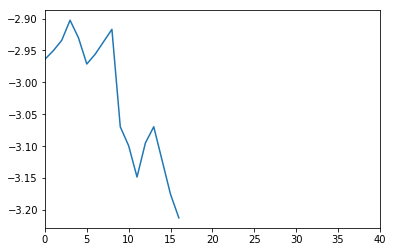

In [34]:
plt.plot(extraboost_evals_result['valid_0']['AMS_eval'])
plt.xlim((0, 40))
plt.show()

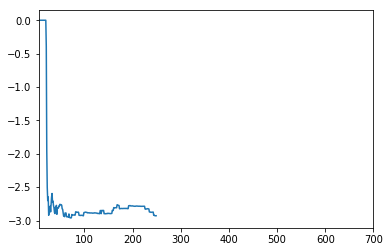

In [35]:
plt.plot(evals_result['valid_0']['AMS_eval'])
plt.xlim((5, 700))
plt.show()

In [36]:
prediction_train = lgb_booster.predict(X_train)
prediction_test = lgb_booster.predict(X_test)
prediction_val = lgb_booster.predict(X_val)
prediction_lgb = lgb_booster.predict(predict_data)

init_prediction_train = init_lgb_booster.predict(X_train)
init_prediction_test = init_lgb_booster.predict(X_test)
init_prediction_val = init_lgb_booster.predict(X_val)
init_prediction_lgb = init_lgb_booster.predict(predict_data)


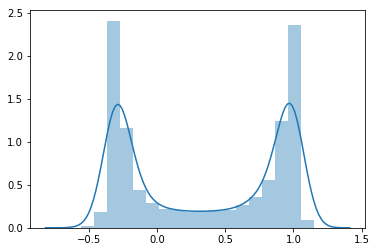

In [41]:
sns.distplot(prediction_test)

### **Metrics**

In [70]:
prob_cut = 0.3

In [71]:
print(classification_report(y_test, prediction_test > prob_cut, sample_weight= [20./ X_test.shape[0]] * y_test.shape[0]))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92 9.998656455728835
           1       0.88      0.98      0.93 10.001343544268401

   micro avg       0.93      0.93      0.93 19.999999999997236
   macro avg       0.93      0.93      0.93 19.999999999997236
weighted avg       0.93      0.93      0.93 19.999999999997236



### **Bootstraping**

In [56]:
val_bootstrap_ids        = [np.random.choice(X_val.index, size=len(X_val), replace=True) for i in range(50)]
val_bootstrap_samples    = [X_val.loc[ids] for ids in val_bootstrap_ids]
val_bootstrap_targets    = [y_val.loc[ids] for ids in val_bootstrap_ids]
val_bootstrap_prediction = [lgb_booster.predict(sample) for sample in val_bootstrap_samples]
val_bootstrap_init_prediction = [init_lgb_booster.predict(sample) for sample in val_bootstrap_samples]

### **AMS optimization**

In [77]:
def some_metric_cut(cut, sig_sum_w = sig_sum_w, bkgr_sum_w = sig_sum_w, br = 0.00000001, prediction = prediction_test, true_labels = y_test):

    TP = (prediction > cut[0]) & (true_labels == 1)
    FP = (prediction > cut[0]) & (true_labels == 0)
    TN = (prediction < cut[0]) & (true_labels == 0)
    FN = (prediction < cut[0]) & (true_labels == 1)
    
    s_weight = sig_sum_w  / np.argwhere(true_labels == 1).shape[0]
    b_weight = bkgr_sum_w / np.argwhere(true_labels == 0).shape[0]
    
    TP *= s_weight; FP *= b_weight
    FN *= s_weight; TN *= b_weight
    TP = sum(TP); FP = sum(FP)
    FN = sum(FN); TN = sum(TN)
  
    acc  = (TP+TN)/(TP+TN+FP+FN) 
    prec = (TP)/(TP+FP) 
    rec = (TP)/(TP+FN)
    
    f1 = 2*prec*rec / (prec + rec)
    
    return f1

In [51]:
%%time
domain = [
        {'name': 'cut', 'type': 'continuous', 'domain': (0.85, 0.999)}
      ]
                     
# cv_params = {'max_depth': [8, 10, 12], 'min_child_weight': [8, 10, 12], 'learning_rate': [0.1, 0.2, 0.3], 'reg_lambda': [0.1], 'colsample_bytree': [1.], 'subsample': [1.]}

# ind_params = {'seed':123, 
#              'objective': 'binary:logistic'}
 

# Optimization objective

Zs = []; cuts = []
Zs_init = []; cuts_init = []
# for prediction, target in zip(val_bootstrap_prediction, val_bootstrap_targets):
# for prediction, target in zip(prediction_test, y_test):
optimizer = BayesianOptimization(f= lambda x: AMS_cut(x, prediction = init_prediction_test, true_labels = y_test, sig_sum_w = sig_sum_w, bkgr_sum_w = bkgr_sum_w), 
#                                  some_metric_cut,
                                 domain=domain,
                                 model_type='GP',
                                 acquisition_type ='MPI',
#                                  n_samples = 5,
                                 evaluator_type = 'local_penalization',
                                 initial_design_numdata = 30,
                                 initial_design_type='sobol',
                                 batch_size = 1,
                                 acquisition_jitter = 0.005,
                                 exact_feval = True, 
                                 maximize = True,
                                 num_cores = 2)

# Only 20 iterations because we have 5 initial random points

# optimizer.run_optimization(max_iter=5, max_time=180, eps=1e-6, verbosity=True, context={'n_estimators':10})
optimizer.run_optimization(max_iter=20, max_time=1800, eps=1e-6, verbosity=True) 
# optimizer.run_optimization(max_iter=10, max_time=180, eps=1e-6, verbosity=True, context={'n_estimators':1000})

Zs.append(-min(optimizer.Y_best))
cuts.append(optimizer.x_opt[0])

# for prediction, target in zip(val_bootstrap_init_prediction, val_bootstrap_targets):
#     optimizer = BayesianOptimization(f= lambda x: AMS_cut(x, prediction = prediction, true_labels = target, sig_sum_w = sig_sum_w, bkgr_sum_w = bkgr_sum_w), 
#     #                                  some_metric_cut,
#                                      domain=domain,
#                                      model_type='GP',
#                                      acquisition_type ='MPI',
#     #                                  n_samples = 5,
#                                      evaluator_type = 'local_penalization',
#                                      initial_design_numdata = 30,
#                                      initial_design_type='sobol',
#                                      batch_size = 1,
#                                      acquisition_jitter = 0.005,
#                                      exact_feval = True, 
#                                      maximize = True,
#                                      num_cores = 2)

#     # Only 20 iterations because we have 5 initial random points

#     # optimizer.run_optimization(max_iter=5, max_time=180, eps=1e-6, verbosity=True, context={'n_estimators':10})
#     optimizer.run_optimization(max_iter=20, max_time=1800, eps=1e-6, verbosity=True) 
#     # optimizer.run_optimization(max_iter=10, max_time=180, eps=1e-6, verbosity=True, context={'n_estimators':1000})

#     Zs_init.append(-min(optimizer.Y_best))
#     cuts_init.append(optimizer.x_opt[0])
    

num acquisition: 1, time elapsed: 0.50s
num acquisition: 2, time elapsed: 1.40s
num acquisition: 3, time elapsed: 1.76s
num acquisition: 4, time elapsed: 2.08s
num acquisition: 5, time elapsed: 3.18s
num acquisition: 6, time elapsed: 4.32s
num acquisition: 7, time elapsed: 5.56s
num acquisition: 8, time elapsed: 6.54s
num acquisition: 9, time elapsed: 7.37s
num acquisition: 10, time elapsed: 8.01s
num acquisition: 11, time elapsed: 8.55s
num acquisition: 12, time elapsed: 9.32s
num acquisition: 13, time elapsed: 10.04s
num acquisition: 14, time elapsed: 10.52s
num acquisition: 15, time elapsed: 10.91s
num acquisition: 16, time elapsed: 11.35s
num acquisition: 17, time elapsed: 11.82s
num acquisition: 18, time elapsed: 12.20s
num acquisition: 19, time elapsed: 12.58s
num acquisition: 20, time elapsed: 12.91s
CPU times: user 27.3 s, sys: 18.8 s, total: 46 s
Wall time: 13.3 s


In [74]:
### accidently put at the array initialization 0 in Zs_init

np.mean(Zs), np.mean(Zs_init[1:])

(2.841401852972276, 2.5813095403634314)

In [75]:
np.sqrt(np.var(Zs)), np.sqrt(np.var(Zs_init[1:]))

(0.2776898560839958, 0.2068198677918337)

In [76]:
from scipy.stats import ttest_1samp

In [77]:
ttest_1samp(np.array(Zs) - np.array(Zs_init[1:]), 0)

Ttest_1sampResult(statistic=10.396021287567875, pvalue=5.4583536852689326e-14)

Bayesian optimization score = 2.97


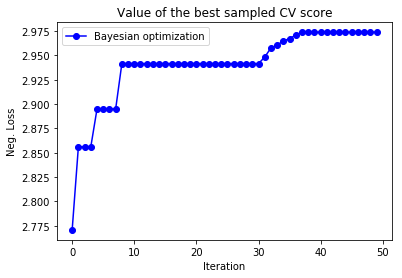

In [52]:
# y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

# print(f'Baseline neg. MSE = {baseline:.2f}')
# print(f'Random search = {y_rs[-1]:.2f}')
print(f'Bayesian optimization score = {y_bo[-1]:.2f}')

# plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. Loss')
# plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();


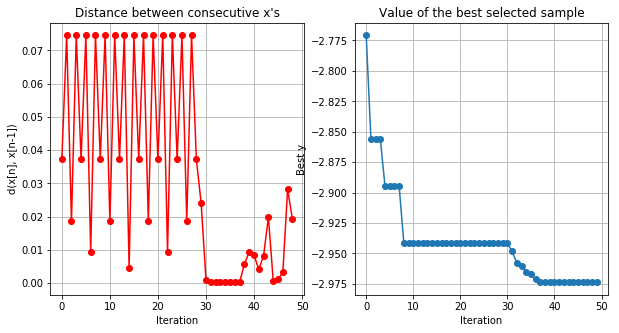

In [53]:
optimizer.plot_convergence()

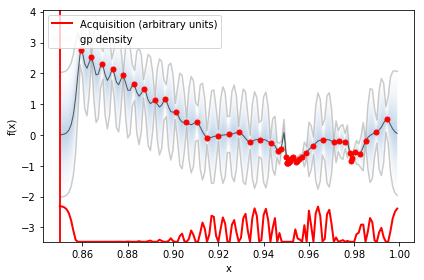

In [54]:
optimizer.plot_acquisition()

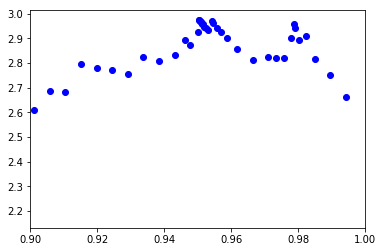

In [55]:
plt.plot(optimizer.X, -optimizer.Y, 'bo')
plt.xlim(0.9, 1.)
plt.show()

In [56]:
optimizer.Y_best

array([-2.77078539, -2.85616234, -2.85616234, -2.85616234, -2.89500186,
       -2.89500186, -2.89500186, -2.89500186, -2.9416665 , -2.9416665 ,
       -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 ,
       -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 ,
       -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 ,
       -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 , -2.9416665 ,
       -2.9416665 , -2.94837958, -2.95777667, -2.9604613 , -2.96515911,
       -2.96717235, -2.97119864, -2.97388269, -2.97388269, -2.97388269,
       -2.97388269, -2.97388269, -2.97388269, -2.97388269, -2.97388269,
       -2.97388269, -2.97388269, -2.97388269, -2.97388269, -2.97388269])

In [57]:
print(f'best signif. = {-min(optimizer.Y_best)} for cut = {optimizer.x_opt[0]:.5f}')

best signif. = 2.9738826862009446 for cut = 0.95036


In [344]:
_f= lambda x: AMS_cut(x, prediction = prediction_test, true_labels = y_test, sig_sum_w = sig_sum_w, bkgr_sum_w = bkgr_sum_w)

In [345]:
_f([0.95096])

3.1856965904765953

In [337]:
_s = (init_prediction_val > 0.96096) & (y_val == 1)
_b = (init_prediction_val > 0.96096) & (y_val == 0)

s_weight = sig_sum_w  / np.argwhere(y_val == 1).shape[0]
b_weight = bkgr_sum_w / np.argwhere(y_val == 0).shape[0]

_s *= s_weight; _b *= b_weight

In [338]:
sum(_s)

52.55945183393793

In [339]:
sum(_b)

429.93416633078067

In [319]:
"""
1 / (5 * 10**1)
best signif. = 3.61394224747856 for cut = 0.94836  -> prediction_test
best signif. = 3.094474738769918 for cut = 0.99363 -> init_prediction_test

best signif. = 2.8800398416069313 for cut = 0.94655 -> prediction_val
best signif. = 2.566854602058145 for cut = 0.96551  -> init_prediction_val

*****
1/10**2 hesse

best signif. = 2.8693450893723913 for cut = 0.96624 -> prediction_val
best signif. = 2.566035311121351 for cut = 0.96555  -> init_prediction_val

*****
1/10**2 hesse
0.6/0.2/0.2 train/test/val splitting (before was 0.8*0.8/0.2/0.8*0.2)

best signif. = 3.3675386711360153 for cut = 0.94228 -> prediction_test
best signif. = 2.9745536796914718 for cut = 0.95030 -> init_prediction_val

best signif. = 2.662086986997766 for cut = 0.96519  -> prediction_val
best signif. = 2.4856542302798026 for cut = 0.96096 -> init_prediction_val

*****
bootstrap, 50 samples

1/10**2 hesse, - 0.01*, 250 pre-train
0.6/0.2/0.2 train/test/val splitting (before was 0.8*0.8/0.2/0.8*0.2)

mean Zs      = 2.841401852972276  +- 0.2776898560839958
mean Zs_init = 2.5813095403634314 +- 0.2068198677918337

"""

'\n1 / (5 * 10**1)\nbest signif. = 3.61394224747856 for cut = 0.94836  -> prediction_test\nbest signif. = 3.094474738769918 for cut = 0.99363 -> init_prediction_test\n\nbest signif. = 2.566854602058145 for cut = 0.96551  -> init_prediction_val\nbest signif. = 2.8800398416069313 for cut = 0.94655 -> prediction_val\n\n*****\n1/10**2 hesse\n\nbest signif. = 2.566035311121351 for cut = 0.96555  -> init_prediction_val\nbest signif. = 2.8693450893723913 for cut = 0.96624 -> prediction_val\n\n****\n0.6/0.2/0.2 train/test/val splitting (before was 0.8*0.8/0.2/0.8*0.2)\n\nbest signif. = 2.662086986997766 for cut = 0.96519 -> prediction_val\nbest signif. = 2.4856542302798026 for cut = 0.96096\n'

### **weighted plots**

In [51]:
sig_weight  = sig_sum_w / np.argwhere(y_test == 1).shape[0]
bkgr_weight = bkgr_sum_w / np.argwhere(y_test == 0).shape[0]

test_df = pd.DataFrame({'BU': test_masses['BU_mass_Cjp'], 'target': y_test, 'prediction': prediction_test})
test_df['weight'] = test_df.apply(lambda x: sig_weight if x['target'] == 1 else bkgr_weight, axis=1)

In [52]:
test_df.head()

,BU,target,prediction,weight
101993,5.379563,1,1.036220,0.013434
150511,5.389379,1,0.958393,0.013434
21463,5.385097,1,0.966659,0.013434
70457,5.290254,0,0.023811,13.437248
87144,5.377891,1,0.936929,0.013434


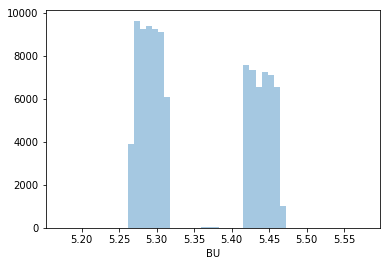

In [53]:
sns.distplot(test_df['BU'], hist_kws={'weights': test_df['weight']}, kde=False)

In [54]:
optimal_cut = optimizer.x_opt[0]

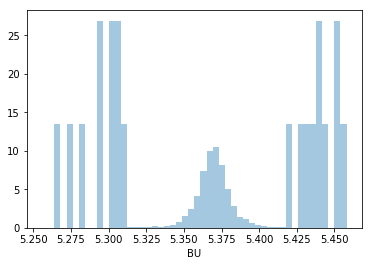

In [55]:
sns.distplot(test_df[test_df['prediction'] > optimal_cut]['BU'], hist_kws={'weights': test_df[test_df['prediction'] > optimal_cut]['weight']}, kde=False, norm_hist = False)

In [56]:
sum(test_df[(test_df['prediction'] > optimal_cut) & (test_df['target'] == 0)]['weight'])

268.74496103198067

In [57]:
AMS_cut([optimal_cut], prediction = prediction_test, true_labels = y_test)

3.4374609856538

### **tests**

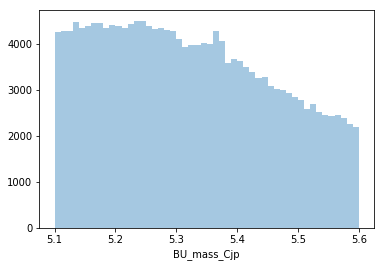

In [138]:
sns.distplot(data['BU_mass_Cjp'], kde=False)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


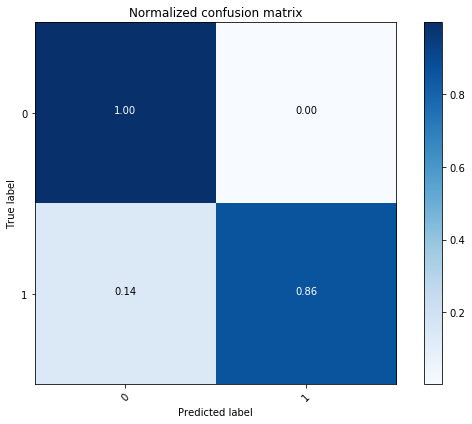

In [56]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(metrics.confusion_matrix(y_test, prediction_test > optimal_cut), classes=['0', '1'], normalize=True,
                      title='Normalized confusion matrix')

In [57]:
print(f'ROC AUC = {metrics.roc_auc_score(y_test, prediction_test)}')
print(f'log loss = {metrics.log_loss(y_test,prediction_test)}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, prediction_test > prob_cut):.3f}')

ROC AUC = 0.9981351479881616
log loss = 0.05750580860820976
Matthews correlation coefficient = 0.959


#### **ROC curve**

In [58]:
fpr, tpr, _ = roc_curve(y_test, prediction_test)
roc_auc = auc(fpr, tpr)

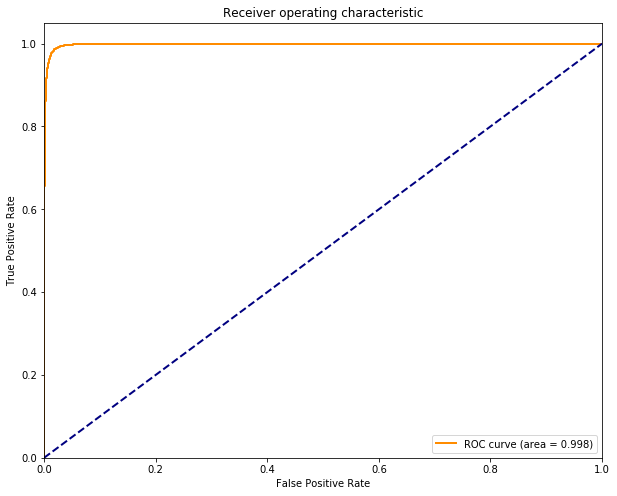

In [59]:
lw = 2
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

### **Final plots**

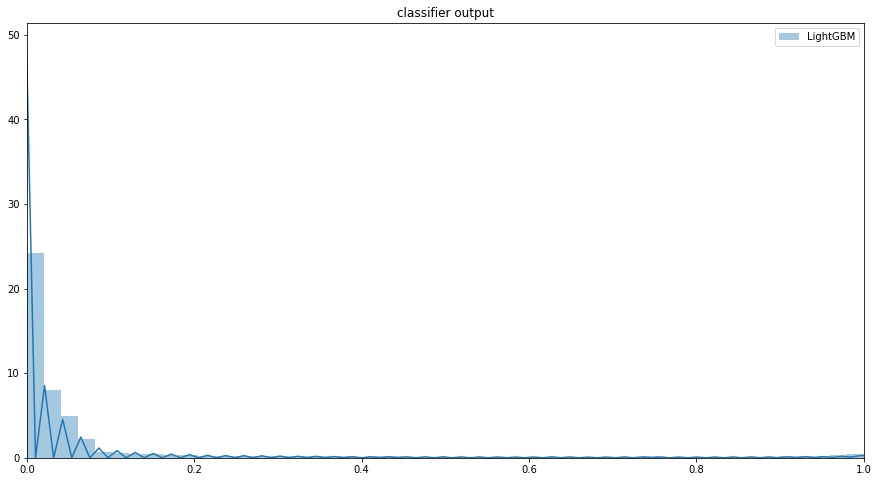

In [60]:
fig, ax = plt.subplots(figsize=(15,8))
# outputs = {'RF': prediction_RF, 'XGBoost': prediction_xgb, 'LogReg': prediction_logreg}
outputs = {'LightGBM': prediction_lgb}

for label, proba in outputs.items():
    sns.distplot(proba, ax=ax, bins=np.linspace(0., 1., num=50,  endpoint=True), label = label, kde=True, hist=True, norm_hist=True)
ax.set_xlim(0., 1.)
ax.set_title('classifier output')

plt.legend()
# plt.yscale('log')
# plt.ylim(10**(-1))

plt.show()

#### **Select masses according to classifier pradiction cut**

With cut > 0.934968415093278 survived 909 out of 76011 for LightGBM


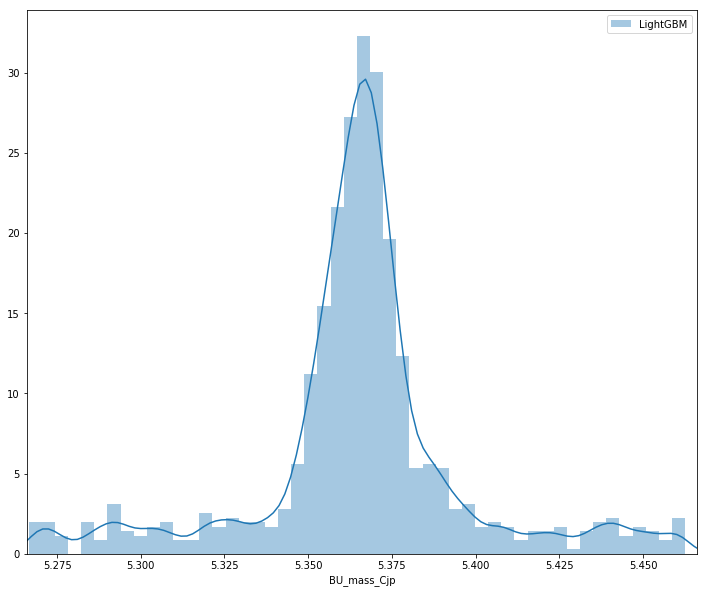

In [61]:
output_cut = optimal_cut
fig, ax = plt.subplots(figsize=(12,10))

for classifier, prediction in outputs.items():
    final_masses = predict_masses.iloc[prediction > output_cut] 
    print(f'With cut > {output_cut} survived {final_masses.shape[0]} out of {predict_masses.shape[0]} for {classifier}')
    sns.distplot(final_masses[('BU_mass_Cjp')], ax=ax, label = classifier, kde=True, hist=True, norm_hist=False)

ax.set_xlim(sig_window['BU_mass_Cjp'][0], sig_window['BU_mass_Cjp'][1])
# ax.set_title('classifier output')

plt.legend()
# plt.yscale('log')
# plt.ylim(10**(-1))

plt.show()

### **Look at masses**

In [62]:
X_train.columns

Index(['BU_pvdistsignif2_Cjp', 'mu_1_pt', 'PI2_eta', 'psi_pt', 'BU_pt_Cjp',
       'K1_pt', 'BU_vtxprob_Cjp', 'mu_2_eta', 'phi_eta', 'psi_mass_Cjp',
       'phi_pt', 'BU_pvdistsignif3_Cjp', 'nB', 'mu_2_pt', 'JP_pt',
       'JPSI_pvcos2_Cmumu', 'K2_eta', 'JPSI_vtxprob_Cmumu', 'K2_pt', 'JP_eta',
       'JPSI_pvdistsignif2_Cmumu', 'JPSI_mass_Cmumu', 'PI2_pt', 'psi_eta',
       'BU_eta_Cjp', 'PHI_mass_Cjp', 'mu_1_eta', 'K1_eta', 'BU_pvcos2_Cjp',
       'PI1_pt', 'PI1_eta', 'PV_bestBang_RF_CL', 'PIPI_mass_Cjp'],
      dtype='object')

In [64]:
vars = ['psi_mass_Cjp'] #   BU_mass_Cjp
test_psi_mass_sig = test_masses[vars].iloc[(prediction_test > output_cut) & (y_test.values == 1)]
test_psi_mass_bkgr = test_masses[vars].iloc[(prediction_test > output_cut) & (y_test.values == 0)]

train_psi_mass_sig = train_masses[vars].iloc[(prediction_train > output_cut) & (y_train.values == 1)]
train_psi_mass_bkgr = train_masses[vars].iloc[(prediction_train > output_cut) & (y_train.values == 0)]

# label_dict = {'test_sig': test_psi_mass_sig, 'test_bkgr': test_psi_mass_bkgr, 'train_sig': train_psi_mass_sig, 'train_bkgr': train_psi_mass_bkgr}
label_dict = {'train_bkgr': train_psi_mass_bkgr, 'test_bkgr': test_psi_mass_bkgr}

With cut > 0.5 survived 903 out of 903
With cut > 0.5 survived 245 out of 245


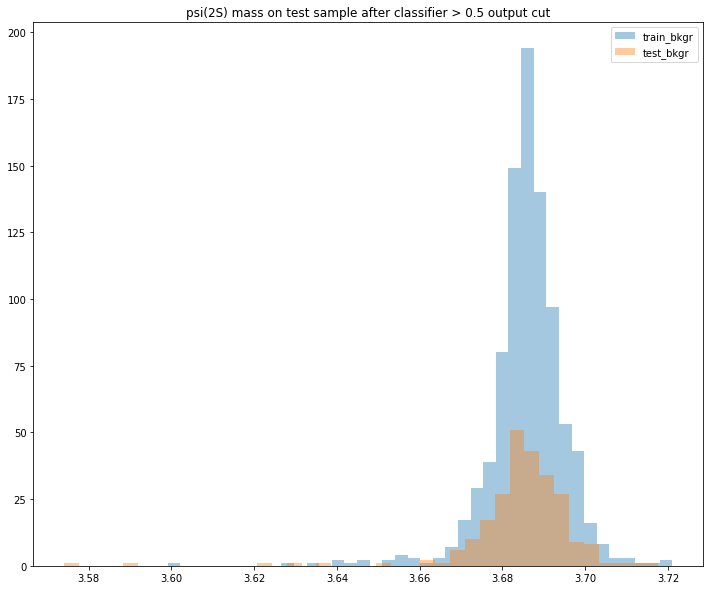

In [65]:
fig, ax = plt.subplots(figsize=(12,10))

# for masses, label in zip((train_psi_mass, test_psi_mass), ('train', 'test')):
for label, masses in label_dict.items():
#     final_masses = masses.iloc[prediction > output_cut] 
    final_masses = masses
    print(f'With cut > {output_cut} survived {final_masses.shape[0]} out of {masses.shape[0]}')
    sns.distplot(final_masses, ax=ax, label = label, bins = 40, kde=False, hist=True, norm_hist=False)

# ax.set_xlim(3.65, 3.72)
ax.set_title('psi(2S) mass on test sample after classifier > 0.5 output cut')

plt.legend()
# plt.yscale('log')
# plt.ylim(10**(-1))

plt.show()

### Scatterplots

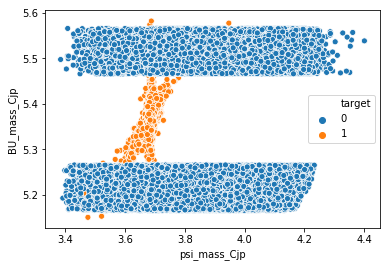

In [66]:
mass_dict_train = {'mass_psi': train_masses['psi_mass_Cjp'], 'mass_psi': train_masses['BU_mass_Cjp'], 'target': y_train}
df_mass_target_train = pd.DataFrame(mass_dict_train)

sns.scatterplot(data = df_mass_target_train, hue='target', x=train_masses['psi_mass_Cjp'], y=train_masses['BU_mass_Cjp'])

In [67]:
mass_to_plot = 'psi_mass_Cjp'  # 'psi_mass_Cjp'    'BU_mass_Cjp'
mass_dict_train = {'mass': train_masses[mass_to_plot], 'prediction': prediction_train, 'target': y_train}
mass_dict_test = {'mass': test_masses[mass_to_plot], 'prediction': prediction_test, 'target': y_test}

mass_df_train = pd.DataFrame(mass_dict_train)
mass_df_test = pd.DataFrame(mass_dict_test)

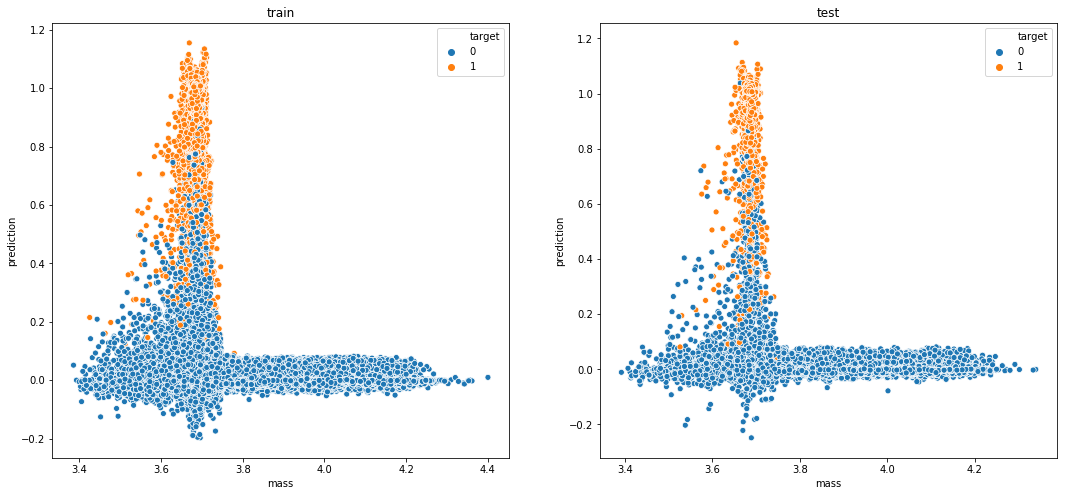

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(data=mass_df_train, hue='target', x='mass', y='prediction', ax=ax1)
sns.scatterplot(data=mass_df_test, hue='target', x='mass', y='prediction', ax=ax2)

ax1.set_title('train')
ax2.set_title('test')
plt.show()

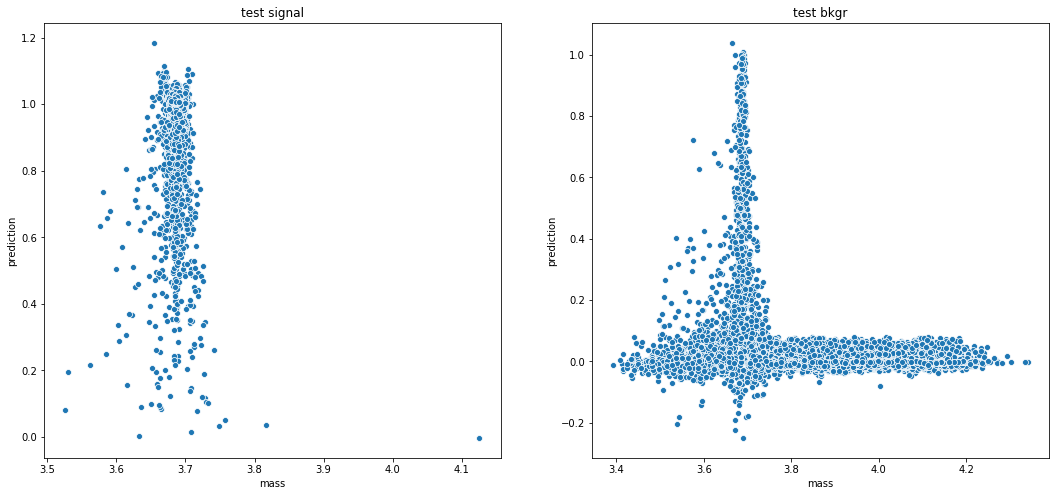

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(x=mass_df_test[(mass_df_test.target == 1)].mass, y=mass_df_test[mass_df_test.target == 1].prediction, ax=ax1)
sns.scatterplot(x=mass_df_test[mass_df_test.target == 0].mass, y=mass_df_test[mass_df_test.target == 0].prediction, ax=ax2)

ax1.set_title('test signal')
ax2.set_title('test bkgr')

# ax1.set_ylim(0, 0.4)
# ax2.set_ylim(0, 0.4)

# ax1.set_xlim(3.65, 3.72)
# ax2.set_xlim(3.65, 3.72)

plt.show()

### **SHAP**

In [74]:
%%time
shap.initjs()

explainer = shap.TreeExplainer(lgb_booster)
shap_values = explainer.shap_values(X_test)

CPU times: user 25.1 s, sys: 22.3 ms, total: 25.1 s
Wall time: 7.05 s


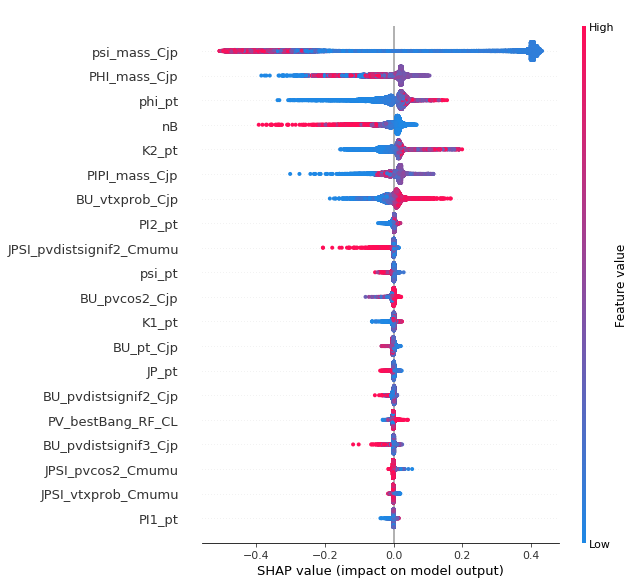

In [75]:
shap.summary_plot(shap_values, X_test)

In [61]:
explainer.expected_value

0.4999268470602373

In [77]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6:700,:], X_test.iloc[6:700,:]) #0-bkgr, 6-sig, on sample wo psi mass

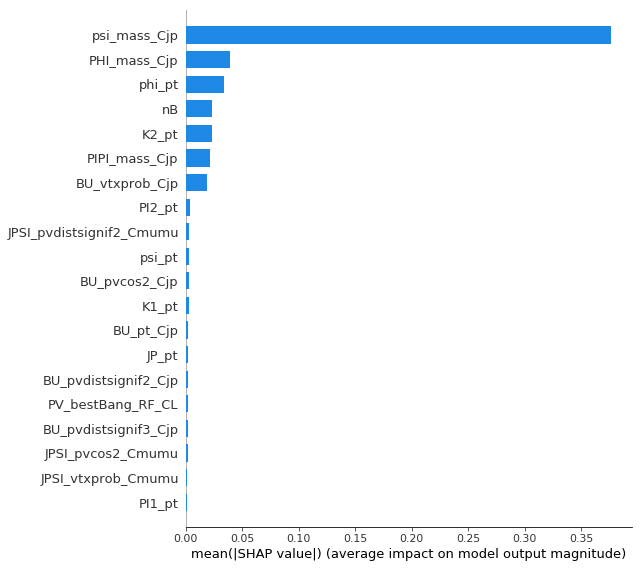

In [76]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Feature selection with statistic tests

In [70]:
feature_scores_mi = mutual_info_classif(X_train_lgb, y_train)

for score, fname in sorted(zip(feature_scores_mi, X_train_lgb.columns), reverse=True)[:10]:
    print(fname, score)

feature_scores_mi /= np.max(feature_scores_mi)

# X_train_new = SelectKBest(mutual_info_classif, k=5).fit_transform(X_train_lgb, y_train)
# X_train_new.shape

PIPI_mass_Cjp 0.23066887717080453
PHI_mass_Cjp 0.22277114996946912
K2_pt 0.19675839880558255
K1_pt 0.19215836279692944
nB 0.1559347606941004
phi_pt 0.15186942959526206
JPSI_vtxprob_Cmumu 0.14425335864484423
JPSI_mass_Cmumu 0.14339629024289113
JPSI_pvdistsignif2_Cmumu 0.08847248285181797
K2_eta 0.08580614225446248


In [ ]:
### isn't precise, in case of regression captures only linear correleation
### you can see it below, where we have the most important features as the ones which are higher for the signal

feature_scores_f, p_values_f = f_classif(X_train_lgb, y_train)
feature_scores_f /= np.max(feature_scores_f)

for score, fname in sorted(zip(feature_scores_f, X_train_lgb.columns), reverse=True)[:10]:
    print(fname, score)
    
# X_train_new = SelectKBest(mutual_info_classif, k=5).fit_transform(X_train_lgb, y_train)
# X_train_new.shape

### **Prepare for training**

In [ ]:
X_train.columns

In [ ]:
uniform_features  = ['psi_mass_Cjp']
# train_features = X_train.columns.drop('psi_mass_Cjp')
train_features = ['PIPI_mass_Cjp', 'PHI_mass_Cjp', 'BU_pvdistsignif2_Cjp']
n_estimators = 20
base_estimator = DecisionTreeClassifier(max_depth=4)

In [ ]:
uboost_clf = uboost.uBoostClassifier(uniform_features=uniform_features, uniform_label=1,
                                     base_estimator=base_estimator, 
                                     n_estimators=n_estimators, train_features=train_features, 
                                     #efficiency_steps=12,
                                     n_threads=4)

In [ ]:
%%time
uboost_clf.fit(X_train[:], y_train[:])

In [ ]:
np.bincount(uboost_clf.predict(X_test))

In [ ]:
print(classification_report(y_test, uboost_clf.predict(X_test)))

### **2**

In [ ]:
flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3., power=1.3, uniform_label=1)
ugbFL = ugb.UGradientBoostingClassifier(loss=flatnessloss, max_depth=3, 
                                       n_estimators=n_estimators, 
                                       learning_rate=0.1, train_features=train_features)

In [ ]:
%%time
ugbFL.fit(X_train[:], y_train[:])

In [ ]:
print(classification_report(y_test, ugbFL.predict(X_test)))

In [ ]:
print(f'ROC AUC = {metrics.roc_auc_score(y_test, uboost_clf.predict_proba(X_test)[:, 1])}')
print(f'log loss = {metrics.log_loss(y_test, uboost_clf.predict(X_test))}')
print(f'Matthews correlation coefficient = {matthews_corrcoef(y_test, uboost_clf.predict(X_test)):.3f}')